# **SINDy Analysis**

In [1]:
# downgrade numpy for SINDy compatiblity (restart kernel afterwards)
%pip install numpy==1.26.4


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# imports
import math
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
from sindy_rl_functions_ema import *
from scipy import stats as stat
from matplotlib.pylab import LinAlgError
print(np.__version__)

1.26.4


In [3]:
#load data
data = pd.read_csv('../Data/GBE_Data_SINDy.csv')

data = data[['participant', 'happiness rating', 'certain reward', 'expected value', 'prediction error', 'CR4', 'CR6', 'CR8', 'EV4', 'EV6', 'EV8', 'PE4', 'PE6', 'PE8', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8', 'LA', 'CA']]

# RHM Replication

In [4]:
# run SINDy with value signalling terms

folds = 1

collect = ['CR', 'EV', 'PE']

occurences = [0 for i in collect]
   
output = {'CR':[], 'EV':[], 'PE':[], 'R^2':[]}

myvar = ['happiness rating']

# value signaling derivative values
controlvars = ['dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']
        
qvalslist = []
control_inputs_training = []
participants= []

data.dropna(subset=['happiness rating'], inplace=True)
list_df = []

# fit each participant
for i in range (1, 50000):
    df1 = data[data['participant'] == i]
    if len(df1) > 0:
            list_df.append(df1)
            participants.append(i)
for df in list_df:
    control_inputs_training.append(np.array(df[controlvars])[0:])
    qvalslist.append(np.array(df[myvar])[0:])


generalized_library, feat_names = SINDYlibrary(myvar, controlvars)
print(feat_names)
repeats = []
exceptionlist = []
coefficient_totals=[[] for i in collect]


for i in range (0,len(list_df)):
        print(i)

        newQ = []
        newC = []
        newQ.append(qvalslist[i])
        newC.append(control_inputs_training[i])

        test = [i for i, x in enumerate(newQ)]
        np.random.seed(100)
        np.random.shuffle(test)

        holdoutsize = 0

        # if fitting population model, use k-fold cross validation
        for kfold in range(0, folds):
            leaveout = [] 
            try:
                model, r2, coefficients = testSINDy(newQ, newC,
                                generalized_library, feat_names, leaveout=leaveout, testing=True, runs=1, errperc=0.005, collect=collect)
                output['R^2'].append(r2)
                totals = coefficients[0]
                values = coefficients[1]
                for i in range(0, len(totals)):
                     if(totals[i] == True):
                         occurences[i] += 1
                for i in range(0, len(values)):
                     coefficient_totals[i].append(values[i])

            except LinAlgError:
                exceptionlist.append(i)
                continue
            
print("Number of participants: ", len(output['R^2']))
print("CR terms: ", occurences[0])  
output['CR'] = coefficient_totals[0]
print("EV terms: ",occurences[1])
output['EV'] = coefficient_totals[1]
print("PE terms: ",occurences[2]) 
output['PE'] = coefficient_totals[2]
pd.DataFrame(output).to_csv('../Outputs/SINDy_RHM.csv')

['happiness rating', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']
0
R^2 = 0.3072883599732058
(happiness rating)' = 0.244 dCR4 + -0.125 dCR8 + 0.096 dEV4 + 0.128 dPE6
1
R^2 = 0.25133867487009043
(happiness rating)' = -0.153 dCR4 + 0.089 dCR6 + 0.265 dCR8 + -0.069 dPE4 + 0.056 dPE8
2
R^2 = 0.37387540045947687
(happiness rating)' = 0.140 dCR6 + -0.090 dEV8 + -0.193 dPE4 + -0.094 dPE6 + 0.131 dPE8
3
R^2 = 0.29402121056841046
(happiness rating)' = -0.046 dCR4 + 0.045 dCR8 + 0.025 dEV4 + -0.055 dEV8 + -0.042 dPE4 + 0.072 dPE8
4
R^2 = 0.5252084376024198
(happiness rating)' = 0.333 dCR8 + -0.128 dPE4 + 0.103 dPE8
5
R^2 = 0.4901747447912046
(happiness rating)' = -0.355 dCR4 + 0.433 dCR8 + 0.536 dEV8 + 0.520 dPE8
6
R^2 = 0.3570773162665025
(happiness rating)' = -0.035 dCR4 + -0.042 dCR8 + -0.020 dEV4 + -0.018 dPE4 + 0.023 dPE8
7
R^2 = 0.5966190213275447
(happiness rating)' = -0.038 dCR4 + 0.055 dCR8 + -0.059 dEV8 + 0.185 dPE8
8
R^2 = 0.5189201936584252
(happiness ratin

In [5]:
# exclude time series that generate an error (low data variability)

exceptions_excluded = []

for i in exceptionlist:
    exceptions_excluded.append(participants[i])

print(f'Exception exclusions (N = {len(exceptions_excluded)}): ', exceptions_excluded)

Exception exclusions (N = 737):  [43, 62, 65, 81, 83, 164, 175, 238, 260, 262, 273, 296, 365, 367, 371, 424, 426, 427, 439, 471, 491, 500, 515, 543, 551, 555, 585, 591, 605, 672, 676, 760, 771, 776, 840, 865, 866, 875, 906, 922, 926, 940, 956, 986, 1018, 1029, 1051, 1054, 1065, 1163, 1204, 1216, 1243, 1254, 1271, 1275, 1278, 1285, 1307, 1321, 1378, 1394, 1420, 1460, 1487, 1505, 1522, 1585, 1612, 1622, 1731, 1750, 1756, 1815, 1823, 1839, 1854, 1868, 1874, 1877, 1878, 1887, 1889, 1891, 1914, 1932, 1935, 1948, 1959, 1971, 1983, 1991, 2008, 2016, 2025, 2030, 2041, 2050, 2063, 2083, 2104, 2107, 2122, 2129, 2173, 2197, 2209, 2213, 2215, 2248, 2272, 2279, 2334, 2335, 2339, 2370, 2428, 2437, 2449, 2455, 2476, 2486, 2513, 2519, 2524, 2550, 2560, 2581, 2599, 2621, 2627, 2664, 2669, 2681, 2712, 2713, 2744, 2755, 2766, 2787, 2826, 2840, 2889, 2916, 2921, 2924, 2930, 2933, 2975, 2981, 2997, 3001, 3036, 3056, 3074, 3102, 3118, 3129, 3162, 3210, 3224, 3239, 3266, 3267, 3317, 3332, 3384, 3423, 3428, 3

In [14]:
# summary statistics

replication = pd.read_csv('../Outputs/SINDy_RHM.csv')
print('Mean R^2', np.mean(replication['R^2']))
print('SD R^2', np.std(replication['R^2']))
print('Median R^2',np.median(replication['R^2']))


Mean R^2 0.4347229377607167
SD R^2 0.19327229302381854
Median R^2 0.4377508088510634


Parameter Means (CR, EV, PE):  6.190074138055135 3.7159000935723028 10.552501259627148
Parameter SDs (CR, EV, PE):  47.31647682055802 20.221435138145715 19.057961660541313
CR > 0:  TtestResult(statistic=15.419341896053382, pvalue=3.3456603897174485e-53, df=13892)
EV > 0:  TtestResult(statistic=21.658802521676414, pvalue=2.455400360188325e-102, df=13892)
PE > 0:  TtestResult(statistic=65.26214608494722, pvalue=0.0, df=13892)
PE > EV:  TtestResult(statistic=29.49370484653406, pvalue=1.7031584819807824e-185, df=13892)


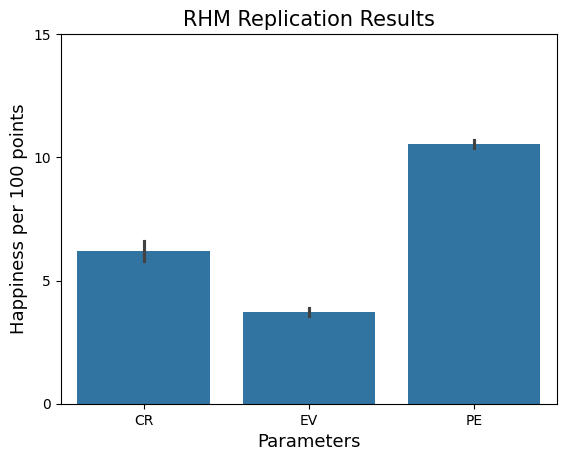

In [7]:
# generate bar chart

hp100 = []
hp100.append([i * 100 for i in replication['CR']])
hp100.append([i * 100 for i in replication['EV']])
hp100.append([i * 100 for i in replication['PE']])

CR = np.mean(hp100[0])
EV = np.mean(hp100[1])
PE = np.mean(hp100[2])

means =[CR, EV, PE]


terms = ['CR', 'EV', 'PE', 'LA', 'CA']
variables = []
vals=[]
for i in range(0, len(hp100)):
    variables += len(hp100[i])*[terms[i]]
    for k in hp100[i]:
        vals.append(k) 
data = {
    "Variables":variables,
    "Values":vals
}

sns.barplot(data=data, x ="Variables", y="Values", errorbar="se")
plt.xlabel('Parameters', fontsize=13)
plt.ylabel('Happiness per 100 points', fontsize=13)
plt.ylim(0,15)
plt.yticks([0, 5, 10, 15])
plt.title('RHM Replication Results', fontsize=15)
plt.savefig('../Figures/SINDy_RHM' + '.png', dpi=1200)

# parameter statistics
print('Parameter Means (CR, EV, PE): ', CR, EV, PE)
print('Parameter SDs (CR, EV, PE): ', np.std(hp100[0]*100), np.std(hp100[1]*100), np.std(hp100[2]*100))
print('CR > 0: ', stat.ttest_1samp(hp100[0], 0))
print('EV > 0: ',stat.ttest_1samp(hp100[1], 0))
print('PE > 0: ',stat.ttest_1samp(hp100[2], 0))
print('PE > EV: ',stat.ttest_rel(hp100[2], hp100[1]))

# DynAffect-C

In [2]:
#load data
data = pd.read_csv('../Data/GBE_Data_SINDy.csv')

data = data[['participant', 'happiness rating', 'certain reward', 'expected value', 'prediction error', 'CR4', 'CR6', 'CR8', 'EV4', 'EV6', 'EV8', 'PE4', 'PE6', 'PE8', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8', 'LA', 'CA']]

In [3]:
# run SINDy with value signaling and attraction terms

folds = 1

collect = ['CR', 'EV', 'PE', 'LA', 'CA']

occurences = [0 for i in collect]
   
output = {'CR':[], 'EV':[], 'PE':[], 'LA':[], 'CA':[], 'R^2':[]}

myvar = ['happiness rating']

controlvars = ['dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8', 'LA', 'CA']
          
qvalslist = []
control_inputs_training = []
participants= []

data.dropna(subset=['happiness rating'], inplace=True)
list_df = []

# fit each participant
for i in range (1, 50000):
    df1 = data[data['participant'] == i]
    if len(df1) > 0:
            list_df.append(df1)
            participants.append(i)
for df in list_df:
    control_inputs_training.append(np.array(df[controlvars])[0:])
    qvalslist.append(np.array(df[myvar])[0:])

generalized_library, feat_names = SINDYlibrary(myvar, controlvars)
print(feat_names)
repeats = []
exceptionlist = []
coefficient_totals=[[] for i in collect]


for i in range (0,len(list_df)):

        print(i)

        newQ = []
        newC = []
        newQ.append(qvalslist[i])
        newC.append(control_inputs_training[i])

        test = [i for i, x in enumerate(newQ)]
        np.random.seed(100)
        np.random.shuffle(test)

        holdoutsize = 0

        # if fitting population model, use k-fold cross validation
        for kfold in range(0, folds):
            leaveout = [] 
            try:
                model, r2, coefficients = testSINDy(newQ, newC,
                                generalized_library, feat_names, leaveout=leaveout, testing=True, runs=1, errperc=0.05, collect=collect)
                output['R^2'].append(r2)
                totals = coefficients[0]
                values = coefficients[1]
                for i in range(0, len(totals)):
                     if(totals[i] == True):
                         occurences[i] += 1
                for i in range(0, len(values)):
                     coefficient_totals[i].append(values[i])

            except LinAlgError:
                exceptionlist.append(i)
                continue
            
print("Number of participants: ", len(output['R^2']))
print("CR terms: ", occurences[0])  
output['CR'] = coefficient_totals[0]
print("EV terms: ",occurences[1])
output['EV'] = coefficient_totals[1]
print("PE terms: ",occurences[2]) 
output['PE'] = coefficient_totals[2]
print("LA terms: ",occurences[3]) 
output['LA'] = coefficient_totals[3]
print("CA terms: ",occurences[4]) 
output['CA'] = coefficient_totals[4]
pd.DataFrame(output).to_csv('../Outputs/SINDy_DC.csv')

['happiness rating', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8', 'LA', 'CA']
0
R^2 = 0.5342361380360994
(happiness rating)' = 0.161 dCR4 + 0.265 dPE8 + 0.410 LA
1
R^2 = 0.4514641078031142
(happiness rating)' = 0.171 dCR8 + 0.388 LA
2
R^2 = 0.6668407653354828
(happiness rating)' = -0.137 dEV8 + -0.135 dPE4 + 0.725 LA
3
R^2 = 0.5035127100140936
(happiness rating)' = 0.097 dCR6 + -0.033 dPE4 + 0.076 dPE8 + 0.665 CA
4
R^2 = 0.6418394389730349
(happiness rating)' = 0.252 dCR8 + 0.047 CA
5
R^2 = 0.5021249021400205
(happiness rating)' = 0.457 dEV8 + 0.432 dPE8 + 0.022 CA
6
R^2 = 0.39446180379284534
(happiness rating)' = -0.071 dCR8 + -0.032 dEV8 + 0.198 LA
7
R^2 = 0.7781990720890394
(happiness rating)' = -0.033 dEV8 + 0.155 dPE8 + 0.562 LA
8
R^2 = 0.6095358671674931
(happiness rating)' = -0.140 dCR4 + 0.254 dEV8 + 0.207 dPE8 + 0.576 LA + -0.440 CA
9
R^2 = 0.5137209457761907
(happiness rating)' = -0.053 dPE4 + 0.261 dPE8 + 0.323 LA
10
R^2 = 0.6692502769650792
(happi

In [4]:
# exclude time series that generate an error (low data variability)

exceptions_excluded = []

for i in exceptionlist:
    exceptions_excluded.append(participants[i])

print(f'Exception exclusions (N = {len(exceptions_excluded)}): ', exceptions_excluded)

Exception exclusions (N = 737):  [43, 62, 65, 81, 83, 164, 175, 238, 260, 262, 273, 296, 365, 367, 371, 424, 426, 427, 439, 471, 491, 500, 515, 543, 551, 555, 585, 591, 605, 672, 676, 760, 771, 776, 840, 865, 866, 875, 906, 922, 926, 940, 956, 986, 1018, 1029, 1051, 1054, 1065, 1163, 1204, 1216, 1243, 1254, 1271, 1275, 1278, 1285, 1307, 1321, 1378, 1394, 1420, 1460, 1487, 1505, 1522, 1585, 1612, 1622, 1731, 1750, 1756, 1815, 1823, 1839, 1854, 1868, 1874, 1877, 1878, 1887, 1889, 1891, 1914, 1932, 1935, 1948, 1959, 1971, 1983, 1991, 2008, 2016, 2025, 2030, 2041, 2050, 2063, 2083, 2104, 2107, 2122, 2129, 2173, 2197, 2209, 2213, 2215, 2248, 2272, 2279, 2334, 2335, 2339, 2370, 2428, 2437, 2449, 2455, 2476, 2486, 2513, 2519, 2524, 2550, 2560, 2581, 2599, 2621, 2627, 2664, 2669, 2681, 2712, 2713, 2744, 2755, 2766, 2787, 2826, 2840, 2889, 2916, 2921, 2924, 2930, 2933, 2975, 2981, 2997, 3001, 3036, 3056, 3074, 3102, 3118, 3129, 3162, 3210, 3224, 3239, 3266, 3267, 3317, 3332, 3384, 3423, 3428, 3

In [13]:
# summary statistics

DC = pd.read_csv('../Outputs/SINDy_DC.csv')
print('Mean R^2', np.mean(DC['R^2']))
print('SD R^2', np.std(DC['R^2']))
print('Median R^2',np.median(DC['R^2']))

Mean R^2 0.6192599274717375
SD R^2 0.19754300740906072
Median R^2 0.6465263203399316


Means (CR, EV, PE, LA, CA):  4.252350104369107 2.9667530410998344 8.720247606708414 31.825055783488086 33.75887857194271
Standard Deviations (CR, EV, PE, LA, CA):  38.612157241004816 15.472513954133996 14.908899040270454 34.49647394668504 300.7453534318275
Percent Included (CR, EV, PE, LA, CA):  0.9056200584087186 0.9153073580739369 0.9487142958900207 0.7393689009188689 0.708526248308284
LA > 0:  TtestResult(statistic=108.73687682606634, pvalue=0.0, df=13892)
CA > 0:  TtestResult(statistic=13.230354244947923, pvalue=1.0189688767090022e-39, df=13892)


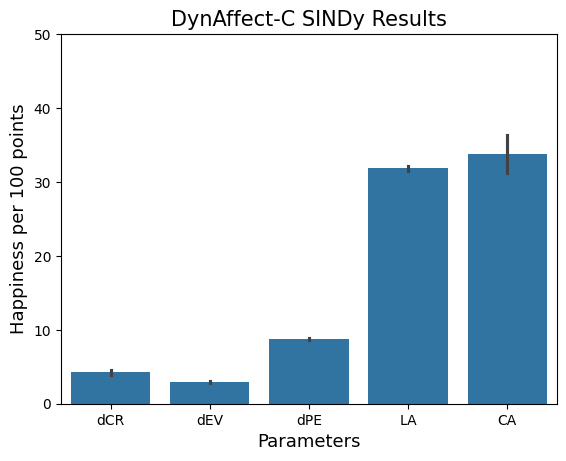

In [11]:
# generate bar chart

hp100 = []
hp100.append([i *100 for i in DC['CR']])
hp100.append([i *100 for i in DC['EV']])
hp100.append([i *100 for i in DC['PE']])
hp100.append([i *100 for i in DC['LA']])
hp100.append([i *100 for i in DC['CA']])

CR = np.mean(hp100[0])
EV = np.mean(hp100[1])
PE = np.mean(hp100[2])
LA = np.mean(hp100[3])
CA = np.mean(hp100[4])

terms = ['dCR', 'dEV', 'dPE', 'LA', 'CA']
variables = []
vals=[]
for i in range(0, len(hp100)):
    variables += len(hp100[i])*[terms[i]]
    for k in hp100[i]:
        vals.append(k) 
data = {
    "Variables":variables,
    "Values":vals
}

sns.barplot(data=data, x ="Variables", y="Values", errorbar="se")
plt.xlabel('Parameters', fontsize=13)
plt.ylabel('Happiness per 100 points', fontsize=13)
plt.ylim(0,15)
plt.yticks([0, 10, 20, 30, 40, 50])
plt.title('DynAffect-C SINDy Results', fontsize=15)
plt.savefig('../Figures/SINDy_DC' + '.png', dpi=1200)

# print parameter statistics
print('Means (CR, EV, PE, LA, CA): ', CR, EV, PE, LA, CA)
print('Standard Deviations (CR, EV, PE, LA, CA): ', np.std(hp100[0]), np.std(hp100[1]), np.std(hp100[2]), np.std(hp100[3]), np.std(hp100[4]))
print('Percent Included (CR, EV, PE, LA, CA): ', 12714/14039, 12850/14039, 13319/14039, 10380/14039, 9947/14039)
print('LA > 0: ',stat.ttest_1samp(hp100[3], 0))
print('CA > 0: ',stat.ttest_1samp(hp100[4], 0))

# Model Comparison

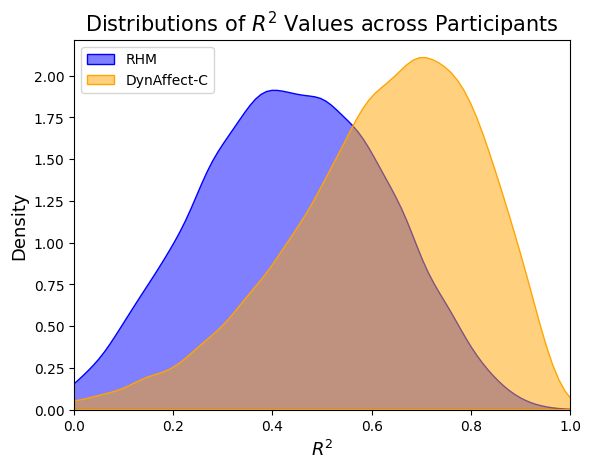

In [15]:
# generate KDE plot

sns.kdeplot(replication['R^2'], fill=True, alpha=0.5, color='blue', label='RHM')
sns.kdeplot(DC['R^2'], fill=True, alpha=0.5, color='orange', label='DynAffect-C')

plt.title('Distributions of $R^2$ Values across Participants', fontsize=15)
plt.xlabel('$R^2$', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.xlim([0, 1])

plt.legend(loc='upper left')
plt.savefig('../Figures/SINDy_comp' + '.png', dpi=1200)
plt.show()